In [1]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro
import torch
import VAE
import ConvEncoderDecoder as CED
import LinearEncoderDecoder as LED
import dataloader
import VAEBayesian
import torch.nn as nn
from pyro.contrib.examples.util import MNIST
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np

In [3]:
USE_CUDA = False
NUM_EPOCHS = 20
TEST_FREQUENCY = 5
train_loader, test_loader = dataloader.setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

#model = VAE.VAE(LED.LinearEncoder(2, 400, 100), LED.LinearDecoder(2, 400, 100))
#model = VAE.VAE(CED.ConvEncoder(2, 200), CED.ConvDecoder(2, 200))
model = VAEBayesian.BayesianVAE(LED.LinearEncoder(2, 400, 100), 2, 400, 100, 100, use_cuda=False)
optimizer = pyro.optim.Adam({'lr': 0.001})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = dataloader.train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = dataloader.evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

In [1]:
from TrainedVAE import TrainedLinearVAE
from TrainedVAE import TrainedConvVAE
import torch
import numpy
import matplotlib.pyplot as plt

tensor(5)


<Figure size 640x480 with 0 Axes>

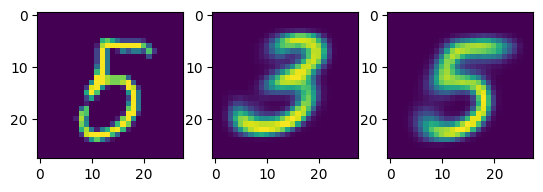

In [18]:
ttest = nn.MaxPool2d(1)

import TrainedVAE
train_loader, test_loader = dataloader.setup_data_loaders(batch_size=100, use_cuda=False)
inputs, classes = next(iter(test_loader)) 
z_mean, z_scale = TrainedVAE.TrainedLinearVAE.encoder(inputs)
z_mean2, z_scale2 = TrainedVAE.TrainedConvVAE.encoder(inputs)
k = 45
s = TrainedVAE.TrainedLinearVAE.decoder(z_mean[k]).detach().numpy().reshape(28, 28)
s2 = TrainedVAE.TrainedConvVAE.decoder(z_mean2[k]).detach().view(1, 1, 28, 28)
s2 = ttest(s2).view(28, 28).numpy()
print(classes[k])

plt.figure()

f, ax = plt.subplots(1, 3)
ax[1].imshow(s)
ax[0].imshow(inputs[k].numpy().reshape(28, 28))
ax[2].imshow(s2)
plt.show()

<AxesSubplot: >

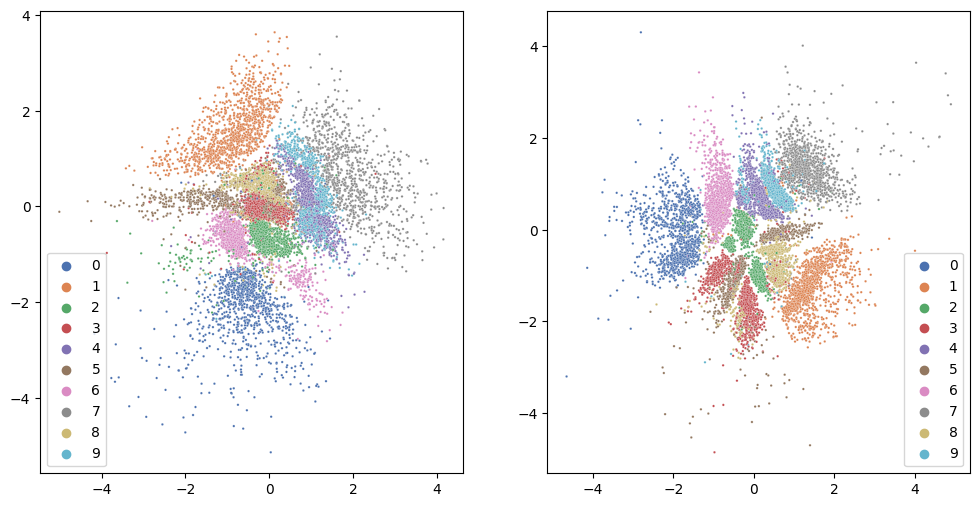

In [10]:
import seaborn as sns
import TrainedVAE
train_loader, test_loader = dataloader.setup_data_loaders(batch_size=60000, use_cuda=False)
inputs, classes = next(iter(test_loader)) 
z_mean, z_scale = TrainedVAE.TrainedLinearVAE.encoder(inputs)
z_mean2, z_scale2 = TrainedVAE.TrainedConvVAE.encoder(inputs)
c = classes.numpy()
z = z_mean.detach().numpy()
z2 = z_mean2.detach().numpy()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(x=z[:,0],y=z[:,1], ax = ax[0], hue=c, palette="deep", s = 3)
sns.scatterplot(x=z2[:,0],y=z2[:,1], ax = ax[1], hue=c, palette="deep", s = 3)

In [ ]:
import pyro.contrib.gp as gp

X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
y = torch.sin(20 * X) + 2 * torch.cos(14 * X) - 2 * torch.sin(6 * X)

In [ ]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0), torch.tensor(2)))
gpmodel = gp.models.GPRegression(X, y, kernel=kernel)

hmc_kernel = pyro.infer.HMC(gpmodel.model)
mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=500)
mcmc.run()

Sample: 100%|██████████| 1000/1000 [00:52, 19.10it/s, step size=5.90e-01, acc. prob=0.891]


ValueError: 'loglog' is not a valid value for scale; supported values are 'linear', 'log', 'symlog', 'asinh', 'logit', 'function', 'functionlog'

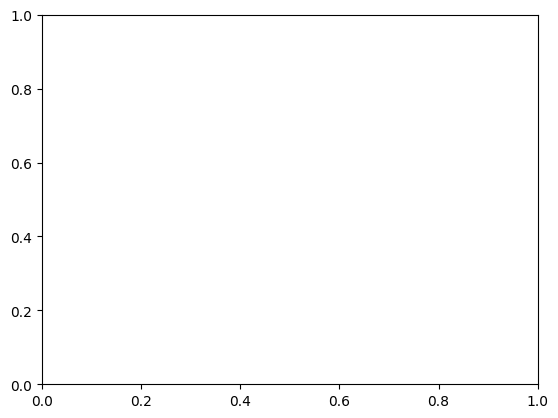

In [ ]:
import seaborn as sns

with torch.no_grad():
    x_new = torch.linspace(-1, 1, 20)
    y_new = gpmodel.forward(x_new)[0]
    
    f, ax = plt.subplots(1)
    ax.set(yscale="loglog")
    sns.lineplot(x = x_new, y = y_new, ax=ax)
    sns.scatterplot(x = X, y = y, ax=ax)
    plt.show()